202102437 이종현
202104271 이대영
202104129 강인학


본 보고서는 서울시 자전거 이용량과 날씨 간의 상관관계 분석을 주제로 했습니다.
본래는 미세먼지와 같은 대기오염이 실외 활동에 미치는 영향을 확인하고자 하였으나,
데이터 수집 과정의 문제와 분석 타당성을 고려하여 날씨(기온, 강수, 적설)처럼 직관적인 변수 중심으로 분석을 진행했습니다.
또한 관광지 방문 데이터는 분석 단위 불일치(월별 vs 일별) 등의 이유로 제외하고,
공공자전거 일별 이용량에 초점을 맞춰 진행했습니다.
추가로 중간계획서에서 이용했던 데이터 수집방식과는 다르게 직접 데이터를 다운로드하였습니다.

날씨 원본 데이터를 일 단위로 집계하기 위해 날짜 기준으로 그룹화하고,
기온은 평균, 강수량과 적설량은 합계로 요약한 후 분석용 데이터프레임을 만들었다.
자전거 데이터와 병합하기 위한 전처리 과정이다.

In [ ]:
#날씨 데이터 전처리

import pandas as pd

weather_path = "OBS_ASOS_DD_20250518195542.csv"
df_weather = pd.read_csv(weather_path, encoding='euc-kr')


df_weather['일시'] = pd.to_datetime(df_weather['일시'])
df_weather['날짜'] = df_weather['일시'].dt.date


df_weather_daily = df_weather.groupby('날짜').agg({
    '평균기온(°C)': 'mean',
    '일강수량(mm)': 'sum',
    '일 최심신적설(cm)': 'sum'
}).reset_index()


df_weather_daily.columns = ['날짜', '기온', '강수량', '적설량']

df_weather_daily.head()


,날짜,기온,강수량,적설량
0,2024-01-01,3.3,0.0,0.0
1,2024-01-02,2.9,0.0,0.0
2,2024-01-03,1.8,0.6,0.0
3,2024-01-04,1.4,0.0,0.0
4,2024-01-05,5.0,0.0,0.0


자전거 데이터를 다운로드 후 확인해보니 용량이 너무 크고 활용하기에 어렵다고 판단하여 월별 데이터 파일 안에 있는 데이터를 이용건수만 확인할 수 있도록 필터링하고 하나의 파일로 합쳐 각각의 파일로 저장했다.

In [ ]:
#자전거 데이터 전처리

import zipfile
import pandas as pd

zip_name = "tpss_bcycl_od_statnhm_20240n.zip"
bike_dfs = []

with zipfile.ZipFile(zip_name, 'r') as z:
    for csv_name in z.namelist():
        try:
            with z.open(csv_name) as f:
                df = pd.read_csv(f, encoding='euc-kr')
                bike_dfs.append(df)

df_bike_all = pd.concat(bike_dfs, ignore_index=True)
df_filtered = df_bike_all[df_bike_all['집계_기준'] == '출발시간']
df_bike_daily_20240n = df_filtered.groupby('기준_날짜')['전체_건수'].sum().reset_index()
df_bike_daily_20240n['날짜'] = pd.to_datetime(df_bike_daily_20240n['기준_날짜'].astype(str), format='%Y%m%d').dt.date
df_bike_daily_20240n = df_bike_daily_20240n[['날짜', '전체_건수']]
df_bike_daily_20240n.columns = ['날짜', '자전거_이용건수']
df_bike_daily_20240n = df_bike_daily_20240n.sort_values('날짜').reset_index(drop=True)

df_bike_daily_20240n.to_csv("bike_daily_20240n.csv", index=False)

df_bike_daily_20240n.head()


✅ 1월 데이터 저장 완료: bike_daily_202401.csv


,날짜,자전거_이용건수
0,2024-01-01,48626
1,2024-01-02,89211
2,2024-01-03,74053
3,2024-01-04,92879
4,2024-01-05,97418


위에서 했던 자전거 데이터 전처리 파일들을 하나로 병합하여 날씨 데이터와 직접 병합하기 위해 하나의 파일로 병합하였다.

In [ ]:
#자전거 데이터 병합

import pandas as pd
import glob

file_paths = sorted(glob.glob("bike_daily_2024*.csv"))

bike_dfs = []
for path in file_paths:
    df = pd.read_csv(path)
    df['날짜'] = pd.to_datetime(df['날짜'])
    bike_dfs.append(df)

df_bike_all = pd.concat(bike_dfs, ignore_index=True).sort_values('날짜')

df_bike_all.to_csv("bike_all_2024.csv", index=False)

print(df_bike_all.head())
print("총 데이터 개수:", df_bike_all.shape)


          날짜  자전거_이용건수
0 2024-01-01   48626.0
1 2024-01-02   89211.0
2 2024-01-03   74053.0
3 2024-01-04   92879.0
4 2024-01-05   97418.0
총 데이터 개수: (365, 2)


날씨 데이터와 자전거 데이터의 전처리를 거친 후 두 데이터를 병합하여 하나의 파일로 만들어 저장하여 전처리 과정을 마무리하였다.

In [ ]:
#날씨 데이터와 자전거 데이터 병합

import pandas as pd

bike = pd.read_csv("bike_all_2024.csv")
bike['날짜'] = pd.to_datetime(bike['날짜'])

weather = pd.read_csv("OBS_ASOS_DD_20250518195542.csv", encoding='euc-kr')
weather['일시'] = pd.to_datetime(weather['일시'])
weather['날짜'] = weather['일시'].dt.date

weather_daily = weather.groupby('날짜').agg({
    '평균기온(°C)': 'mean',
    '일강수량(mm)': 'sum',
    '일 최심신적설(cm)': 'sum'
}).reset_index()

weather_daily['날짜'] = pd.to_datetime(weather_daily['날짜'])
weather_daily.columns = ['날짜', '기온', '강수량', '적설량']

merged = pd.merge(bike, weather_daily, on='날짜', how='inner')

merged.to_csv("bike_weather_2024.csv", index=False)



          날짜  자전거_이용건수   기온  강수량  적설량
0 2024-01-01   48626.0  3.3  0.0  0.0
1 2024-01-02   89211.0  2.9  0.0  0.0
2 2024-01-03   74053.0  1.8  0.6  0.0
3 2024-01-04   92879.0  1.4  0.0  0.0
4 2024-01-05   97418.0  5.0  0.0  0.0
✅ 병합된 데이터 크기: (365, 5)


프로젝트의 첫 번째 분석 단계에서는 자전거 이용량과 날씨 변수 간의 관계를 파악하기 위해 상관관계 분석을 수행하였다. 분석에 사용된 변수는 총 네 가지로, 종속 변수인 자전거_이용건수와 독립 변수인 기온(°C), 강수량(mm), 적설량(cm)이다.

상관계수는 피어슨 상관계수를 기준으로 계산되었고, pandas의 .corr() 메서드를 통해 상관계수 행렬을 구한 뒤 시각화하였다. 시각화 그래프에서는 폰트 문제로 한글이 깨져 보일 수 있지만, 행과 열 순서대로 각각 자전거_이용건수, 기온, 강수량, 적설량이 들어가 있다.

히트맵을 통해 확인한 상관관계 값은 다음과 같았다. 자전거_이용건수와 기온 사이의 상관계수는 0.50으로, 이는 기온이 높을수록 자전거 이용량이 증가하는 중간 정도의 양의 상관관계를 나타낸다. 반면 강수량과 적설량은 각각 -0.33, -0.22로 자전거 이용량과 음의 상관관계를 보였지만, 그 강도는 비교적 약한 편이었다. 날씨 변수들 간에는 다중공선성 문제가 나타날 정도로 높은 상관은 확인되지 않았다.

이러한 결과를 바탕으로, 기온은 자전거 사용량에 영향을 미칠 가능성이 높은 주요 변수로 판단되며, 강수나 적설은 사용을 저해하는 요인일 수 있으나 영향력은 상대적으로 작을 것으로 보인다.

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44144 (\N{HANGUL SYLLABLE GEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr

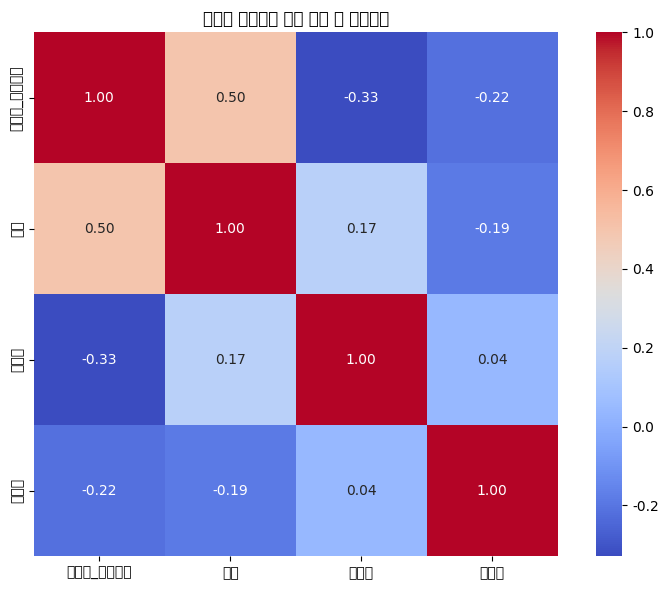

In [ ]:
#상관관계 분석 후 히트맵으로 시각화하기

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("자전거 이용량과 날씨 변수 간 상관관계")
plt.tight_layout()
plt.show()


두 번째 분석 단계에서는 자전거 이용량 데이터의 구성 요소를 분해하여
추세, 계절성, 불규칙성을 시각적으로 파악하기 위한
시계열 분해 분석을 수행하였다.

분석 대상은 위에서 병합한 파일에 저장된 전체 2024년 자전거 이용량 데이터이며,
날짜 컬럼을 시계열 인덱스로 설정한 후,주기는 1주일(7일)을 기준으로 설정하였다.

하지만 처음 그래프를 그렸을 때, 이상값이나 자전거 이용량의 급격한 변동 때문에 그래프가 깨지거나, 그래프가 왜곡되어 보이는 문제가 발생하였다.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/seasonal.py:360: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/seasonal.py:360: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/seasonal.py:360: UserWarning: Glyph 44144 (\N{HANGUL SYLLABLE GEO}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/seasonal.py:360: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/seasonal.py:360: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/seasonal.py:360: UserWarning: Glyph 44148 (\N{HANG

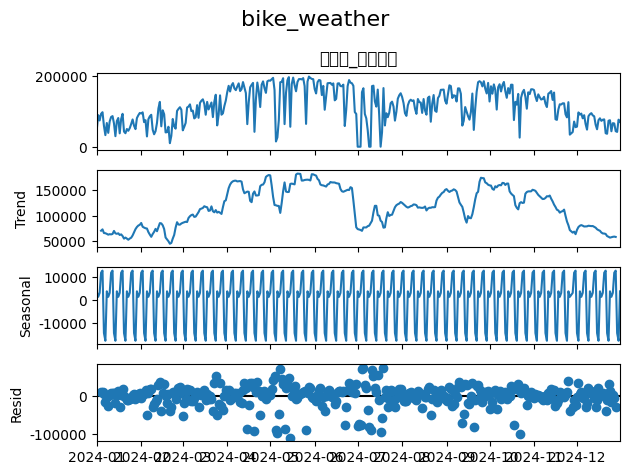

In [ ]:
#시계열 분해 분석 - 1차

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

df = pd.read_csv("bike_weather_2024.csv")
df['날짜'] = pd.to_datetime(df['날짜'])
df = df.set_index('날짜')

result = seasonal_decompose(df['자전거_이용건수'], model='additive', period=7)

result.plot()
plt.suptitle("bike_weather", fontsize=16)
plt.tight_layout()
plt.show()


앞서 수행한 시계열 분해 분석에서는 일부 극단적인 값이나 진폭 차이로 인해
그래프의 해석이 어려웠다. 이러한 문제를 보완하기 위해,이번에는 자전거 이용량 데이터에 로그 변환(log1p) 을 적용해서 진폭을 줄이고 진행하였다.
결과적으로 보다 안정적이고 해석 가능한 그래프가 출력되었다.
자전거 이용량 데이터에 로그 변환을 적용한 후, 시계열 분해 분석을 수행하였다.
로그 변환은 극단적인 이상값의 영향을 줄이고, 데이터 분산을 안정화하여
시계열 분해 결과를 보다 명확하게 해석할 수 있도록 돕는다.

첫 번째로, 전체 시계열은 로그 스케일에서도 전반적으로 안정된 값을 유지하고 있었으며,
6월 중순에 일시적으로 급감하는 구간이 눈에 띄었다. 이는 실제 자전거 이용량이 크게 감소한 시점을
로그 변환 후에도 여전히 반영하고 있음을 보여준다.

두 번째로, 추세항목에서는 연초부터 5월까지 완만한 증가세를 보이다가
6월에 급격히 하락한 후 7월부터 다시 회복세로 돌아서는 흐름을 나타냈다.
이는 외부 요인(기상 악화, 시스템 장애 등)에 의한 일시적 수요 급감 가능성을 시사한다.

세 번째로, 계절성은 전체 기간 동안 매우 규칙적인 주기성을 유지했다.
7일 단위로 반복되는 상승과 하강의 패턴이 뚜렷하게 나타났으며, 이는 평일과 주말 간
자전거 이용량 차이를 반영하는 것으로 해석할 수 있다. 이 계절성은 거의 모든 시점에 걸쳐 일정한 폭을 유지하며,
모델이 주기적 패턴을 잘 포착했음을 보여준다.

마지막으로, 잔차는 전반적으로 안정적인 모습을 보였으며,
대부분의 날은 계절성과 추세로 잘 설명되었다.
다만 6월 중순에는 잔차 값이 급격히 하락하거나 튀는 이상값이 다수 발생했으며,
이 구간은 시계열적 구조로 설명되지 않는 외부 요인의 영향을 받았을 가능성이 높다. 그래서 직접 데이터셋을 확인해보니 6월 22일의 데이터값이 현저히 적었다.이 외에도 적은 데이터값들이 있어 날씨 데이터도 확인을 해보니 강수량도 확인할 수 있었는데 정확히 비가 원인이라기보단 부가적인 원인이 있었을 거라 판단된다.

결론적으로, 시계열 분해는 자전거 이용량의 구조를 명확하게 드러내 주었으며,
주간 계절성과 전반적인 증가 추세를 동시에 파악할 수 있게 해주었다.


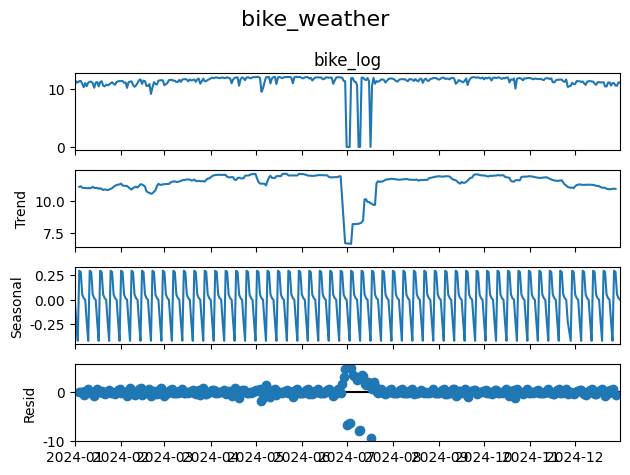

In [ ]:
#시계열 분해 분석 - 2차

import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

df['bike_log'] = np.log1p(df['자전거_이용건수'])

result = seasonal_decompose(df['bike_log'], model='additive', period=7)

result.plot()
plt.suptitle("bike_weather", fontsize=16)
plt.tight_layout()
plt.show()


다변량 시계열 예측을 위한 VAR 모델을 적용하기 전에
각 변수들이 정상 시계열인지 확인하기 위해 단위근 검정을 진행하였다.
정상성은 시계열 분석에서 필수 전제 조건으로,
시계열의 평균과 분산이 시간에 따라 일정해야 예측 모형이 의미가 있다.

우선 자전거 이용량과 날씨 변수(기온, 강수량, 적설량)의 1차 차분을 수행하여
비정상성을 제거한 후 실시하였다.

검정 결과, 모든 변수의 ADF p-value가 0.0000에 수렴할 정도로 매우 작게 나타났으며,
이는 비정상성 존재인 귀무가설을 무시해도 된다를 의미한다.
따라서 자전거 이용량과 날씨 변수들은 정상성을 만족했다.
이후 VAR 모형의 적합과 예측을 위한 사전 조건이 충족되었다.



In [ ]:
#VAR 모델 구성 전에 정상성 확인하기

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("bike_weather_2024.csv")
df['날짜'] = pd.to_datetime(df['날짜'])
df = df.set_index('날짜')

data = df[['자전거_이용건수', '기온', '강수량', '적설량']]

data_diff = data.diff().dropna()

for col in data_diff.columns:
    result = adfuller(data_diff[col])
    print(f" {col} - ADF p-value: {result[1]:.10f}")


 자전거_이용건수 - ADF p-value: 0.0000000000
 기온 - ADF p-value: 0.0000129202
 강수량 - ADF p-value: 0.0000000000
 적설량 - ADF p-value: 0.0000000000


위에서 분석한 방법들을 토대로 2025년 1월의 자전거 이용량을 예측해보고자 다변량 자기회귀모델을 구성해보았다.

먼저 자전거 이용량과 세 가지 날씨 변수(기온, 강수량, 적설량)를 포함한 시계열 데이터에
차분을 적용해 정상성을 확보하였고,
VAR 함수로 모델을 학습시켰다.
모델 학습 시에는 AIC 정보 기준에 따라 최적의 시차(lag)를 자동으로 선택하도록 설정하였다.

학습이 완료된 VAR 모델을 이용해 31일치 데이터를 예측한 후,
차분 데이터였던 예측값을 누적합과 마지막 실제값을 더하는 방식으로 원래 스케일로 복원하였다.
이를 통해 2025년 1월의 일별 자전거 이용량 예측치를 얻을 수 있었다.

이 모델이 제대로 구성되었는지 확인하기 위해 2025년 1월의 자전거 이용량 데이터를 수집하여 직접 확인하고 싶었지만 아직 업로드되어 있지 않은 관계로 2025년 1월의 날씨 데이터를 수집하여 비교해보기로 했다.



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


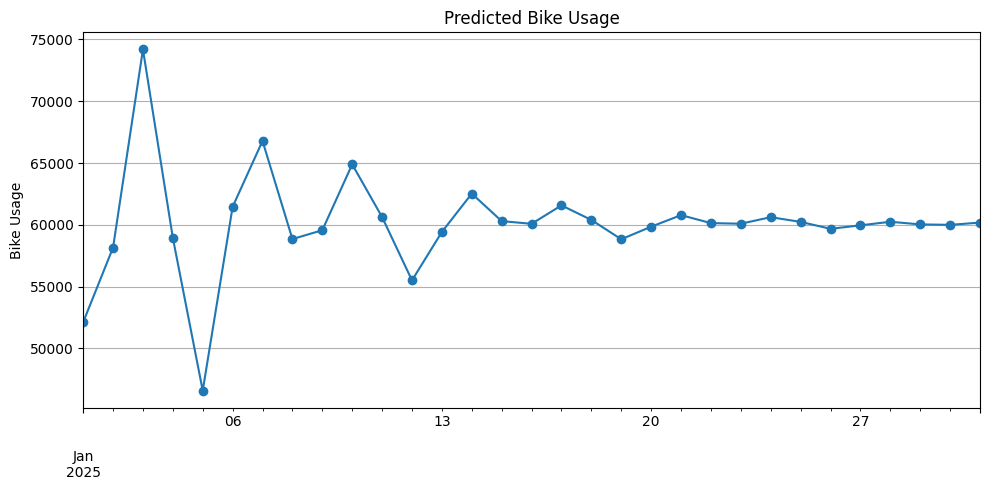

In [ ]:
#VAR 모델 구성하고 시각화하기

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

df = pd.read_csv("bike_weather_2024.csv")
df['날짜'] = pd.to_datetime(df['날짜'])
df = df.set_index('날짜')

data = df[['자전거_이용건수', '기온', '강수량', '적설량']]

data_diff = data.diff().dropna()

model = VAR(data_diff)
results = model.fit(maxlags=15, ic='aic')  # 자동 래그 선택

forecast = results.forecast(data_diff.values[-results.k_ar:], steps=31)

forecast_df = pd.DataFrame(forecast, columns=data_diff.columns)
forecast_df.index = pd.date_range(start=data_diff.index[-1] + pd.Timedelta(days=1), periods=31)
forecast_df = forecast_df.cumsum() + data.iloc[-1]

plt.figure(figsize=(10, 5))
forecast_df['자전거_이용건수'].plot(marker='o')
plt.title("Predicted Bike Usage")
plt.ylabel("Bike Usage")
plt.grid()
plt.tight_layout()
plt.show()

forecast_df.to_csv("forecast_VAR_202501.csv")


자전거 이용량 예측 결과와 비교하기 위해,
기상청에서 제공한 2025년 1월 일별 기상 데이터를 기반으로
평균 기온, 강수량, 적설량의 변화를 시각화하였다.

날씨 변화는 전반적으로 안정적인 가운데 일부 날짜에서만 뚜렷한 이벤트가 관찰되었다.

기온은 -10도에서 +5도 사이에서 등락을 반복하였으며,
특히 1월 9일에는 -10도에 가까운 최저 기온이 확인되고,
1월 말에도 급격한 기온 하락이 다시 나타났다.
중순에는 비교적 온화한 날씨가 이어졌으며, 기온은 0도에서 4도 사이로 유지되었다.

강수량은 대부분의 날에서 0mm로 유지되었고,
눈에 띄는 강우는 없었고 총 9일 정도만 비가 관측될 수치로 왔다.그마저도 얕은 수치였다.
적설은 1월 5일, 7일, 13일, 27일, 28일, 29일, 31일 사이에 관측되었으며,
그 외의 날에는 적설량이 없었다.


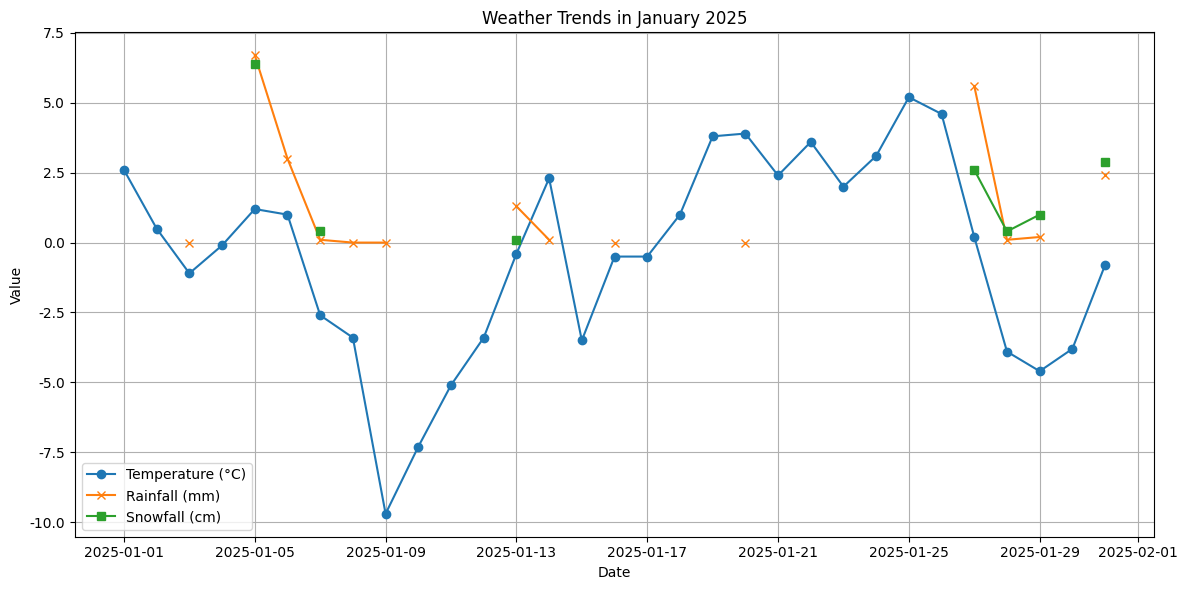

In [ ]:
#날씨 데이터로 보조 분석

import pandas as pd
import matplotlib.pyplot as plt

weather = pd.read_csv("OBS_ASOS_DD_20250601200352.csv", encoding='euc-kr')
weather = weather[['일시', '평균기온(°C)', '일강수량(mm)', '일 최심신적설(cm)']]
weather.columns = ['date', 'temp', 'rainfall', 'snow']
weather['date'] = pd.to_datetime(weather['date'])

weather = weather[(weather['date'].dt.year == 2025) & (weather['date'].dt.month == 1)]

plt.figure(figsize=(12, 6))
plt.plot(weather['date'], weather['temp'], label='Temperature (°C)', marker='o')
plt.plot(weather['date'], weather['rainfall'], label='Rainfall (mm)', marker='x')
plt.plot(weather['date'], weather['snow'], label='Snowfall (cm)', marker='s')
plt.title("Weather Trends in January 2025")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#결론 및 인사이트

2024년 자전거 이용량과 날씨 데이터를 기반으로 예측 모델을 만들어 자전거 사용량을 예측해보았는데 전체적으로 현실적인 이용량 범위에 있었고 일정한 흐름과 주기성을 보여주었으나,일부 시점 특히 1월 5일 강수 직후에는 자전거 수요 예측이 급격히 감소하는 등
날씨 변화가 예측값에 반영된 사례가 확인되었다.
다만, 전체적인 흐름에서는 기온이나 강수량의 급격한 변화와 예측값 사이의
연관성이 크다고 하기는 어려웠으며 부분적으로만 반응이 관찰되었다.
즉, 날씨 변수(기온, 강수량, 적설량)와의 직접적인 연관성은 전 구간에서 뚜렷하게 드러나지 않았다.
이는 모델이 자전거 이용량 자체의 과거 패턴에 더 큰 영향을 받은 결과로 해석된다.

또한 요일, 공휴일, 정책 등 다른 외부 요인이 포함되지 않아
날씨 변수만으로는 자전거 수요를 충분히 설명하기 어렵다는 한계도 확인할 수 있었다.
따라서 향후에는 보다 다양한 변수들을 포함한 예측 모델 확장이 필요하며,
날씨 변수의 영향도 일정 조건 이상일 때만 반응한다는 점에서 조건부 해석이 필요하다.